As part of this take home assignment, you will be using Orekit as your base motion model to propagate the satellite state. This Jupyter notebook will demonstrate how to set up and utilize the Orekit Python Wrapper for satellite propagation.

## Setup

You are recomended to utilize a virtual environment for their code development. The instructions below will guide you on setting up the Orekit Python Wrapper. We will be using Miniconda for this example but you are free to use the virtual environment manager of your choice. Installation instructions for Miniconda can be found here: [Miniconda](https://docs.anaconda.com/miniconda/install/)

1. Create a virtual environment:
> conda create -n orekit_venv python=3.8

2. Activate the virtual environment:
> conda activate orekit_venv

3. Install Orekit using conda
> conda install -c conda-forge orekit=12.1.2

4. Install dependencies using pip
> pip install pandas numpy matplotlib pyarrow fastparquet git+https://gitlab.orekit.org/orekit/orekit-data.git

In [1]:
import orekit
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.frames import FramesFactory
from org.orekit.orbits import CartesianOrbit
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions, PVCoordinates

from utils import OrbitPropagator

Here, we will demonstrate how to initialize an object using position and velocity in the WGS84 reference frame that is used by the provided GNSS data.

In [2]:
# Initialize propagator class and frame
propagator = OrbitPropagator()
conventions = IERSConventions.IERS_2010
itrf     = FramesFactory.getITRF(conventions, True)  
eme2000  = FramesFactory.getEME2000()
utc = TimeScalesFactory.getUTC()              

# initial Cartesian state in WGS-84 / ITRF  (example)
epoch = AbsoluteDate(2024, 5, 21, 0, 0, 0.000, utc)
x, y, z    = 6573086.2, 1718724.3, 14429.7 # WGS84 position in meter
vx, vy, vz = -1102.5, 4117.8, 6007.1 # WGS84 velocity in meter/second

pv_itrf = PVCoordinates(
    Vector3D(x, y, z),
    Vector3D(vx, vy, vz)
)

# Transform PV from ITRF → EME2000 at the provided epoch
frame_transformation     = itrf.getTransformTo(eme2000, epoch)
pv_eme2000 = frame_transformation.transformPVCoordinates(pv_itrf)

# Build the CartesianOrbit in EME2000 for propagation
mu    = Constants.WGS84_EARTH_MU
orbit = CartesianOrbit(pv_eme2000, eme2000, epoch, mu)

duration = 86400.0 # Propagation duration in seconds

# This can be used to visualize intermediate propagation results, however, it is not 
# required and you can set the step to be the propagation duration.
secs = 60.0
mins = 10
step = secs * mins # propagation step size [s]

# Propagate from initial orbit, you can optionally not provide an input to the step 
# argument
tspan, propagated_states = propagator.propagate_from_state(orbit, duration=duration, step=step)

final_time = tspan[-1]
final_state = propagated_states[-1]
final_pv = final_state.getPVCoordinates()
final_pos = final_pv.getPosition()
final_vel = final_pv.getVelocity()

print(f"Final time: {final_time}")
print(f"Final position [km]: X={final_pos.getX()/1e3:.3f}, Y={final_pos.getY()/1e3:.3f}, Z={final_pos.getZ()/1e3:.3f}")
print(f"Final velocity [km/s]: VX={final_vel.getX()/1e3:.6f}, VY={final_vel.getY()/1e3:.6f}, VZ={final_vel.getZ()/1e3:.6f}")


Final time: 2024-05-22T00:00:00.000Z
Final position [km]: X=2111.360, Y=6438.503, Z=-515.800
Final velocity [km/s]: VX=-4.683577, VY=1.070005, VZ=-5.967718


Visualize 3D trajectory of the propagated object

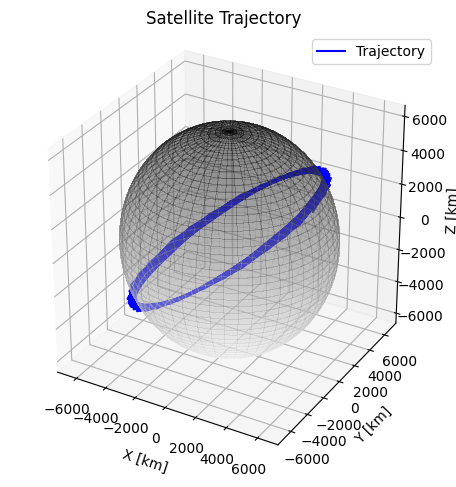

In [3]:
propagator.plot_orbit(propagated_states)